# 14. U-net

Until now we have only seen reasonably small and simple networks. Most *real* networks are much larger and complex and we are going to see how one implement such a network here, namely the U-net.

The U-net (*[U-Net: Convolutional Networks for Biomedical Image Segmentation, Ronneberger et al. 2015](https://arxiv.org/abs/1505.04597)*) is one of the most popular architecture used for segmentation. It is a fully convolutional network bringing the additional advantage that it is not limited to a certain image size. It takes its name from its visual representation where a encoder downsizing the input is followed by a decoder increasing it again:

In [2]:
from IPython.display import Image

# set path containing data folder or use default for Colab (/gdrive/My Drive)
local_folder = "../"
import urllib.request
urllib.request.urlretrieve('https://raw.githubusercontent.com/guiwitz/DLImaging/master/utils/check_colab.py', 'check_colab.py')
from check_colab import set_datapath
colab, datapath = set_datapath(local_folder)

In [3]:
Image(url='https://github.com/guiwitz/DLImaging/raw/master/illustrations/unet.jpg', width=800)

As can be seen in the graphics above, the U-net is composed of a series of convolutional layers followed by activations and max-pooling for the encoding part and a series of convolutional layers followed by activations up-convolutions (transpose convolutions). This is very similar to the sort of architecture we have seen in the [Autoencoder](Autoencoder_drawings.ipynb) notebook.

However, additionally, in the decoding part, layers from the encoder are directly **concatenated** with layers from the decoder. Encoder-decoder architecture often have the problem that small-scale details are lost (see previous chapter), and these *skip-connections* correct for that by adding back layers where these details have not been "washed-out" yet.

## Implementation

For the sake of simplicity, we are creating here a very simple Unet, with just one convolution per depth and with only one depth level. Our input is a single image. We load one and apply the necessary transform:

In [3]:
from pathlib import Path

import torch
from torch import nn, optim
from torch.functional import F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger

from sklearn.metrics import jaccard_score

import skimage.io
import matplotlib.pyplot as plt

We load an image as an example:

In [4]:
image = skimage.io.imread(datapath.joinpath('data/triangle_circle_noisy_seg/images/image_0.tif'))

We define a transform for our image:

In [5]:
transform = transforms.Compose([transforms.ToTensor()])

In [6]:
im_tensor = transform(image)
im_batch = im_tensor.unsqueeze(0)

In [7]:
im_batch.shape

torch.Size([1, 1, 32, 32])

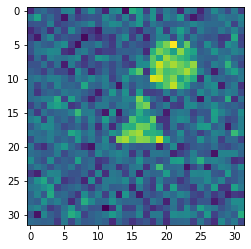

In [8]:
plt.imshow(image);

Now we create the first convolution layer of the first depth level. We also apply ReLU on the output:

In [9]:
conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)

In [10]:
x1 = F.relu(conv1(im_batch))

Note that unlike what we did previously, passsing a ```x``` variables across layers, we will give specific names to the outputs of different layers. We need that so that we can use those layers in the skip-connections!

Now we have a max-pooling layer:

In [13]:
maxpool1 = nn.MaxPool2d(kernel_size=2)

In [14]:
x = maxpool1(x1)

In [15]:
x.shape

torch.Size([1, 16, 16, 16])

Now we can do two new rounds of convolution/pooling. We double the number of filters while we halve the image size:

In [16]:
conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
maxpool2 = nn.MaxPool2d(kernel_size=2)
conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)

In [17]:
x2 = F.relu(conv2(x))
x = maxpool2(x2)
x3 = F.relu(conv3(x))

In [18]:
x3.shape

torch.Size([1, 64, 8, 8])

We have arrived at the "bottom" of the Unet. Now we have to do the reverse step. And don't forget to add the skip connections! First, we do an upconvolution:

In [19]:
transpose_conv3 = nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=2, padding=0, stride=2)

In [20]:
x2_t = transpose_conv3(x3)

In [21]:
x2_t.shape

torch.Size([1, 32, 16, 16])

Now we can combine this with the ```x2``` output which has the same size:

In [22]:
x2.shape

torch.Size([1, 32, 16, 16])

For that we *concatenate* the two outputs:

In [23]:
x = torch.cat((x2, x2_t),dim=1)
x.shape

torch.Size([1, 64, 16, 16])

Finally we add the convolution layer at that depth:

In [24]:
conv2_t = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, padding=1)

In [25]:
x = F.relu(conv2_t(x))
x.shape

torch.Size([1, 32, 16, 16])

Now we repeat the operation:

In [26]:
transpose_conv2 = nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=2, padding=0, stride=2)
conv1_t = nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, padding=1)


In [27]:
x = transpose_conv2(x)
x = torch.cat((x1, x),dim=1)
x = F.relu(conv1_t(x))
x.shape

torch.Size([1, 16, 32, 32])

So we are back to our original size! The last thing we have to do is reduce our stack of size 16 to the number of classes used in the segmentation that we can then use for e.g. soft-max:

In [28]:
num_classes = 3

conv_final = nn.Conv2d(in_channels=16, out_channels=num_classes, kernel_size=1)

In [29]:
x = conv_final(x)
x.shape

torch.Size([1, 3, 32, 32])

## Assembling in a module

We can now assemble all these steps in a Lightning module as we have done before:

In [132]:
class Unet(pl.LightningModule):
    def __init__(self, num_classes, learning_rate):
        super(Unet, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.transpose_conv3 = nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=2, padding=0, stride=2)
        self.conv2_t = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, padding=1)
        self.transpose_conv2 = nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=2, padding=0, stride=2)
        self.conv1_t = nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, padding=1)
        self.conv_final = nn.Conv2d(in_channels=16, out_channels=num_classes, kernel_size=1)
        
        self.loss = nn.CrossEntropyLoss()
        
        self.learning_rate = learning_rate
        
    def forward(self, x):
        
        x1 = F.relu(self.conv1(x))
        x = self.maxpool1(x1)
        x2 = F.relu(self.conv2(x))
        x = self.maxpool2(x2)
        x3 = F.relu(self.conv3(x))
        x2_t = self.transpose_conv3(x3)
        x = torch.cat((x2, x2_t),dim=1)
        x = F.relu(self.conv2_t(x))
        x = self.transpose_conv2(x)
        x = torch.cat((x1, x),dim=1)
        x = F.relu(self.conv1_t(x))
        x = self.conv_final(x)
        
        return x
        
    def training_step(self, batch, batch_idx):
        
        x, y = batch
        output = self(x)
        loss = self.loss(output, y)
        
        #self.log("Loss/Train", loss, on_epoch=True, prog_bar=True, logger=True)
        self.logger.experiment.add_scalar("Loss/Train", loss, self.current_epoch)

        return loss
    
    def validation_step(self, batch, batch_idx):
        
        x, y = batch
        output = self(x)
        output_proj = output.argmax(dim=1)
        jaccard = jaccard_score(y.view(-1), output_proj.view(-1), average='macro')

        #self.log("Jaccard/Valid", jaccard, on_epoch=True, prog_bar=True, logger=True)
        self.logger.experiment.add_scalar("Jaccard/Valid", jaccard, self.current_epoch)

        
        return jaccard
        
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        

Now we can instantiate our model:

In [50]:
unet = Unet(num_classes=3, learning_rate=1e-3)

## Dataset

We use once again our triangle/circle synthetic dataset:

In [126]:
transform = transforms.Compose([transforms.ToTensor()])

class Segdata(Dataset):
    def __init__(self, im_path, label_path, transform=None):
        super(Segdata, self).__init__()
        self.im_path = im_path
        self.label_path = label_path
        self.transform = transform

    def __getitem__(self, index):
        
        x = skimage.io.imread(self.im_path.joinpath(f'image_{index}.tif'))
        if self.transform is not None:
            x = self.transform(x)
        
        y = skimage.io.imread(self.label_path.joinpath(f'labels_{index}.tif'))
        y = torch.tensor(y, dtype=torch.int64)
        
        return x, y

    def __len__(self):

        return len(list(im_path.glob('*.tif')))


im_path = Path('../data/triangle_circle_seg/images')
lab_path = Path('../data/triangle_circle_seg/labels')

#im_path = Path('../data/triangle_circle_noisy_seg/images')
#lab_path = Path('../data/triangle_circle_noisy_seg/labels')

segdata = Segdata(im_path, lab_path, transform)
train_size = int(0.8 * len(segdata))
valid_size = len(segdata)-train_size

train_data, valid_data = random_split(segdata, [train_size, valid_size])
train_loader = DataLoader(train_data, batch_size=20)
validation_loader = DataLoader(valid_data, batch_size=20)

## First test

Before we train our network, let's verify that everything is working properly:

In [127]:
test_image, test_label = next(iter(train_loader))

In [128]:
test_image.shape

torch.Size([20, 1, 32, 32])

In [129]:
test_label.shape

torch.Size([20, 32, 32])

In [130]:
out = unet(test_image)

In [131]:
out.shape

torch.Size([20, 3, 32, 32])

## Training

In [134]:
unet = Unet(num_classes=3, learning_rate=1e-3)

logger = TensorBoardLogger("tb_logs", name="unet_triangle")
trainer = pl.Trainer(max_epochs=10, logger=logger)

GPU available: False, used: False
TPU available: None, using: 0 TPU cores


Finding the optimal learning rate (lr) can be complicated. As an example of how to solve this problem, we briefly highlight here that Lightning implements a method to find the optimal lr. Essentially, it tries different lr, and keeps the one that "moves fastest" in the right direction, in other words it finds the point with highest slope in a Loss vs. lr plot.

In [135]:
lr_finder = trainer.tuner.lr_find(unet,train_dataloader=train_loader, val_dataloaders=validation_loader,early_stop_threshold=None,
                                min_lr=1e-5, max_lr=0.1)


   | Name            | Type             | Params
------------------------------------------------------
0  | conv1           | Conv2d           | 160   
1  | maxpool1        | MaxPool2d        | 0     
2  | conv2           | Conv2d           | 4.6 K 
3  | maxpool2        | MaxPool2d        | 0     
4  | conv3           | Conv2d           | 18.5 K
5  | transpose_conv3 | ConvTranspose2d  | 8.2 K 
6  | conv2_t         | Conv2d           | 18.5 K
7  | transpose_conv2 | ConvTranspose2d  | 2.1 K 
8  | conv1_t         | Conv2d           | 4.6 K 
9  | conv_final      | Conv2d           | 51    
10 | loss            | CrossEntropyLoss | 0     
------------------------------------------------------
56.7 K    Trainable params
0         Non-trainable params
56.7 K    Total params
/Users/gw18g940/miniconda3/envs/CASImaging/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. C

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /Users/gw18g940/GoogleDrive/BernMIC/Trainings/CAS_DLimaging/CASImaging/notebooks/lr_find_temp_model.ckpt


In [136]:
lr_finder.suggestion()

0.0010964781961431851

<ipython-input-137-e87f252efa22>:2: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


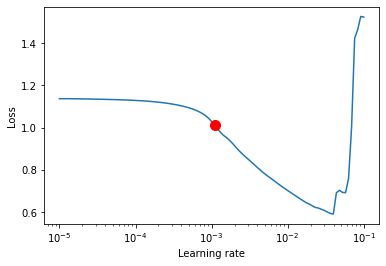

In [137]:
fig = lr_finder.plot(suggest=True)
fig.show()

We see that this value of ```lr = 0.001``` that we often used by default is actually often indeed a good choice.

In [138]:
del unet
unet = Unet(num_classes=3, learning_rate=1e-3)

In [141]:
logger = TensorBoardLogger("tb_logs", name="unet_triangle")
trainer = pl.Trainer(max_epochs=30, logger=logger)
trainer.fit(unet, train_dataloader=train_loader, val_dataloaders=validation_loader)

GPU available: False, used: False
TPU available: None, using: 0 TPU cores

   | Name            | Type             | Params
------------------------------------------------------
0  | conv1           | Conv2d           | 160   
1  | maxpool1        | MaxPool2d        | 0     
2  | conv2           | Conv2d           | 4.6 K 
3  | maxpool2        | MaxPool2d        | 0     
4  | conv3           | Conv2d           | 18.5 K
5  | transpose_conv3 | ConvTranspose2d  | 8.2 K 
6  | conv2_t         | Conv2d           | 18.5 K
7  | transpose_conv2 | ConvTranspose2d  | 2.1 K 
8  | conv1_t         | Conv2d           | 4.6 K 
9  | conv_final      | Conv2d           | 51    
10 | loss            | CrossEntropyLoss | 0     
------------------------------------------------------
56.7 K    Trainable params
0         Non-trainable params
56.7 K    Total params
/Users/gw18g940/miniconda3/envs/CASImaging/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader,

Validation sanity check: 0it [00:00, ?it/s]

/Users/gw18g940/miniconda3/envs/CASImaging/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

1

In [57]:
%load_ext tensorboard
%tensorboard --logdir tb_logs

Reusing TensorBoard on port 6006 (pid 588), started 1 day, 5:04:52 ago. (Use '!kill 588' to kill it.)

In [142]:
val_iter = iter(validation_loader)
test_batch, test_label = next(val_iter)

In [143]:
pred = unet(test_batch)

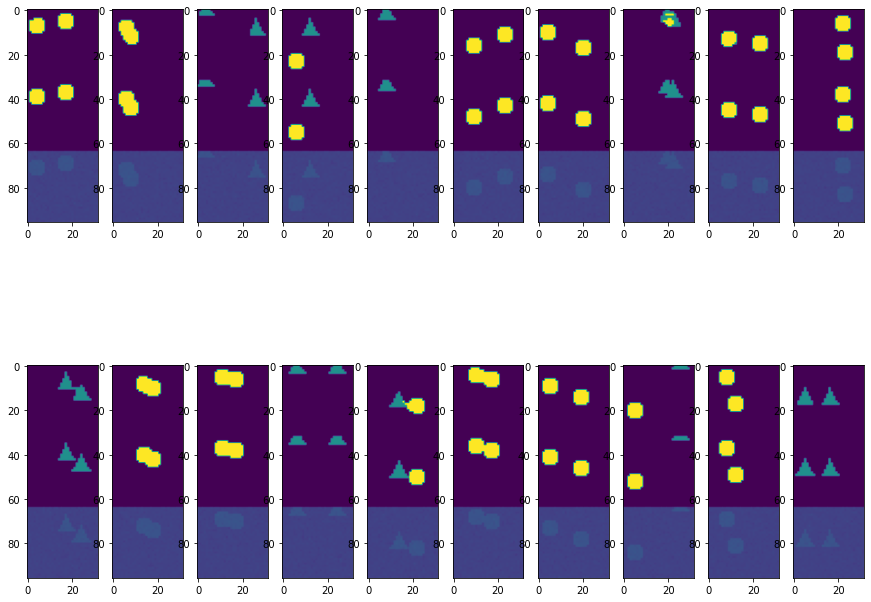

In [144]:
fig = plt.figure(figsize=(15,12))
spec = fig.add_gridspec(ncols=10, nrows=2)

ind=0
for row in range(2):
    for col in range(10):
        
        ax = fig.add_subplot(spec[row, col])
        ax.imshow(torch.cat((pred[ind].argmax(dim=0),test_label[ind], test_batch[ind,0])),vmin=0,vmax=2)
        ind +=1